# Project: Analysis of Developer Social Networks

This notebook analyzes the social networks of developers who starred popular
**machine learning** or **web development** repositories (with at least 10 stars)
up to August 2019. Each network is a largest component of at least 10 users.

**Nodes**: Developer (user) accounts.
**Edges**: Undirected (follower relationships).
**Labels**: Binary (0 = Web dev, 1 = ML dev).

The goal is to **decide** whether a network belongs to **web** or **ML** developers.
Below we:
- Load data from `git_edges.json` (dictionary of graphs) and `git_target` (labels).
- Inspect basic statistics (histograms, distributions).
- Extract structural features for classification.
- Perform a community detection experiment.
- Compare Node2Vec vs. spectral embeddings.

## 1. Imports and Setup

In [ ]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from networkx.algorithms import community
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import igraph as ig
import leidenalg
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


try:
    import community as community_louvain
except ImportError:
    print("Install python-louvain for Louvain: pip install python-louvain")

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict

ModuleNotFoundError: No module named 'sklearn'

## 2. Load Data (from dictionary-format JSON)
Here, we load JSON where each key is a graph ID and the value is a list of edges.
Then, we align these graphs with a target CSV specifying whether each graph
belongs to web (0) or ML (1).

In [ ]:
# Load the JSON file
with open('github_stargazers\git_edges.json', 'r') as f:
    full_data = json.load(f)

# Sort keys and extract edge lists for ALL graphs
sorted_keys = sorted(full_data.keys(), key=int)
edge_lists = [full_data[k] for k in sorted_keys]

# Load the CSV file
targets_df = pd.read_csv('github_stargazers\git_target.csv', index_col=0)

# Extract ALL labels
labels = [targets_df.loc[int(k), "target"] for k in sorted_keys]

print(f"Loaded {len(edge_lists)} graphs")
print("Example graph:", edge_lists[0][:5])


<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
/var/folders/qk/g2d67vns3fq15rbqpxmhdrqm0000gn/T/ipykernel_61229/2791409925.py:2: SyntaxWarning: invalid escape sequence '\g'
  with open('github_stargazers\git_edges.json', 'r') as f:
/var/folders/qk/g2d67vns3fq15rbqpxmhdrqm0000gn/T/ipykernel_61229/2791409925.py:10: SyntaxWarning: invalid escape sequence '\g'
  targets_df = pd.read_csv('github_stargazers\git_target.csv', index_col=0)


/var/folders/qk/g2d67vns3fq15rbqpxmhdrqm0000gn/T/ipykernel_61229/2791409925.py:2: SyntaxWarning: invalid escape sequence '\g'
  with open('github_stargazers\git_edges.json', 'r') as f:
/var/folders/qk/g2d67vns3fq15rbqpxmhdrqm0000gn/T/ipykernel_61229/2791409925.py:10: SyntaxWarning: invalid escape sequence '\g'
  targets_df = pd.read_csv('github_stargazers\git_target.csv', index_col=0)


FileNotFoundError: [Errno 2] No such file or directory: 'github_stargazers\\git_edges.json'

In [ ]:
import os
import json
import pandas as pd

path = os.path.join('github_stargazers', 'git_edges.json')
with open(path, 'r') as f:
    full_data = json.load(f)

# Sort keys and extract edge lists for ALL graphs
sorted_keys = sorted(full_data.keys(), key=int)
edge_lists = [full_data[k] for k in sorted_keys]

# Load the CSV file
targets_df = pd.read_csv('github_stargazers/git_target.csv', index_col=0)

# Extract ALL labels
labels = [targets_df.loc[int(k), "target"] for k in sorted_keys]

print(f"Loaded {len(edge_lists)} graphs")
print("Example graph:", edge_lists[0][:5])

Loaded 12725 graphs
Example graph: [[0, 16], [1, 16], [2, 16], [3, 16], [3, 19]]


## 3. Convert to NetworkX Graphs
We parse each edge list into an undirected NetworkX Graph.

In [ ]:
graphs = []
for edges in tqdm(edge_lists):
    G = nx.Graph()
    valid_edges = [tuple(e) for e in edges if len(e) >= 2]
    G.add_edges_from(valid_edges)
    graphs.append(G)

print(f"First graph: {graphs[0].number_of_nodes()} nodes, {graphs[0].number_of_edges()} edges")

100%|██████████| 12725/12725 [00:04<00:00, 2671.81it/s]

First graph: 71 nodes, 78 edges


## 4. Dataset Statistics
Basic stats about all loaded graphs.

In [ ]:
num_nodes = [g.number_of_nodes() for g in graphs]
num_edges = [g.number_of_edges() for g in graphs]
densities = [nx.density(g) for g in graphs]

print("# Nodes:", np.min(num_nodes), "to", np.max(num_nodes))
print("# Edges:", np.min(num_edges), "to", np.max(num_edges))
print("Density:", round(np.mean(densities), 4))

label_counts = pd.Series(labels).value_counts()
print("\nLabel distribution:")
print(label_counts)

# Nodes: 10 to 957
# Edges: 9 to 4668
Density: 0.0781

Label distribution:
1    6808
0    5917
Name: count, dtype: int64


## 5. Visualize Sample Graphs
We'll show a few example graphs from each label category (web=0, ml=1).


Sample graphs for label 0:


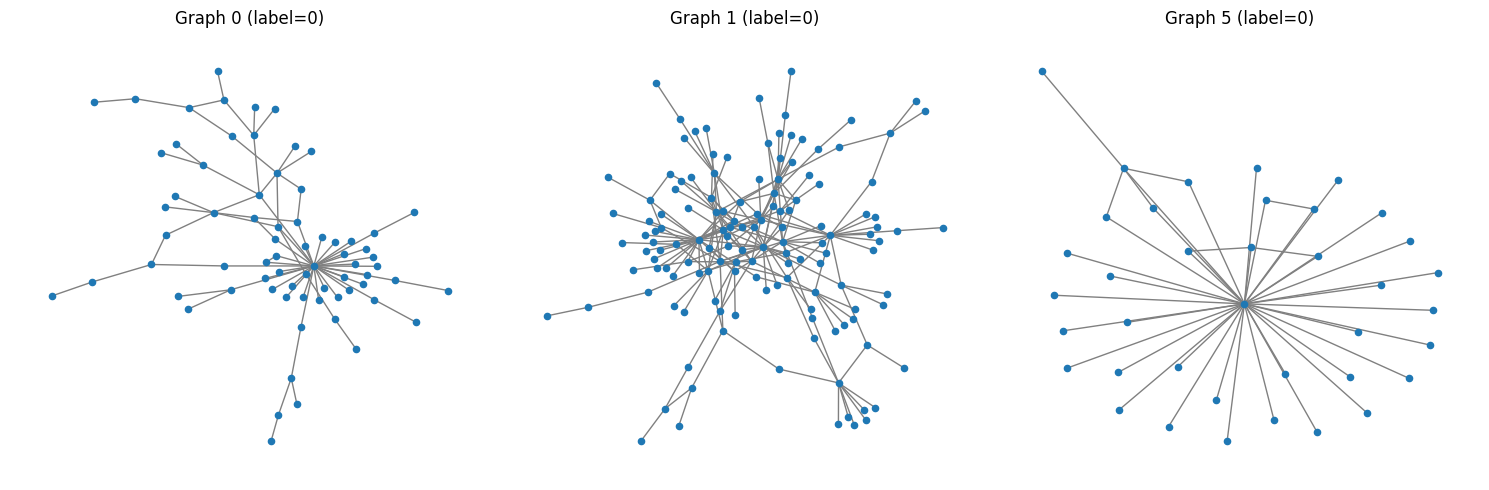


Sample graphs for label 1:


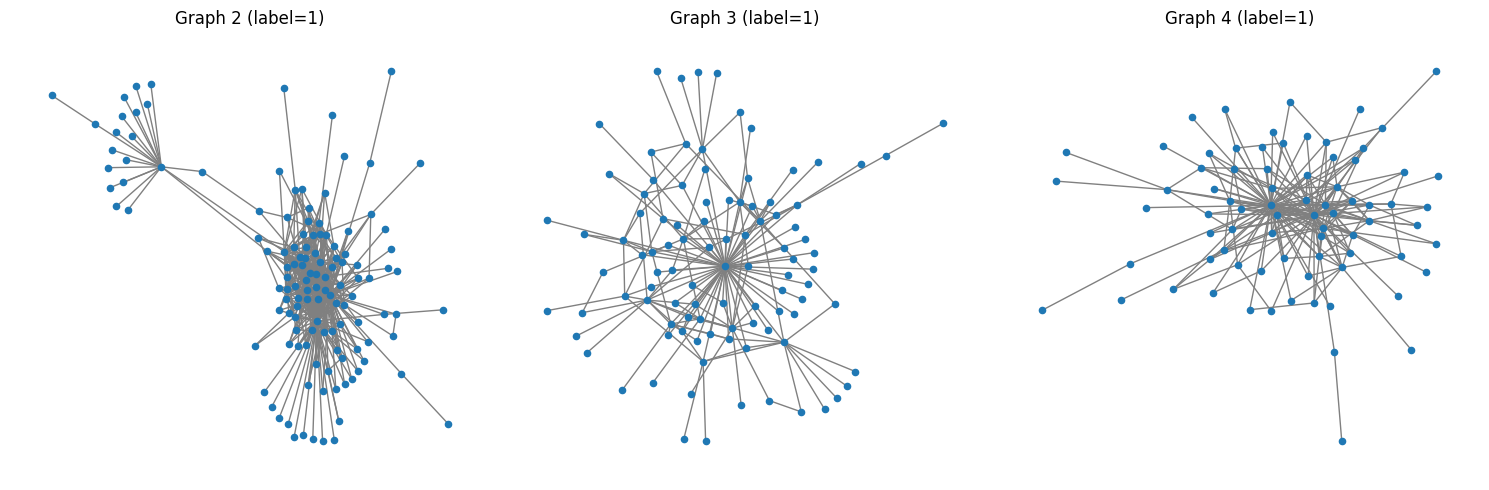

In [ ]:
def plot_graph(g, ax, title):
    pos = nx.spring_layout(g, seed=42)
    nx.draw(g, pos, node_size=20, edge_color='gray', ax=ax)
    ax.set_title(title)
    ax.axis('off')

# Show 3 graphs from each class in a subplot layout
for label in [0, 1]:
    print(f"\nSample graphs for label {label}:")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    count = 0
    for i, g in enumerate(graphs):
        if labels[i] == label:
            plot_graph(g, axes[count], f"Graph {i} (label={label})")
            count += 1
            if count == 3:
                break
    plt.tight_layout()
    plt.show()


Graph 1:
  Number of nodes: 71
  Number of edges: 78
  Is the graph connected? True
  Average degree: 2.20
  Maximum degree: 34
  Minimum degree: 1
------------------------------
Graph 2:
  Number of nodes: 137
  Number of edges: 203
  Is the graph connected? True
  Average degree: 2.96
  Maximum degree: 25
  Minimum degree: 1
------------------------------
Graph 3:
  Number of nodes: 128
  Number of edges: 440
  Is the graph connected? True
  Average degree: 6.88
  Maximum degree: 79
  Minimum degree: 1
------------------------------
Graph 4:
  Number of nodes: 99
  Number of edges: 173
  Is the graph connected? True
  Average degree: 3.49
  Maximum degree: 59
  Minimum degree: 1
------------------------------
Graph 5:
  Number of nodes: 77
  Number of edges: 207
  Is the graph connected? True
  Average degree: 5.38
  Maximum degree: 54
  Minimum degree: 1
------------------------------
Graph 6:
  Number of nodes: 38
  Number of edges: 43
  Is the graph connected? True
  Average degre

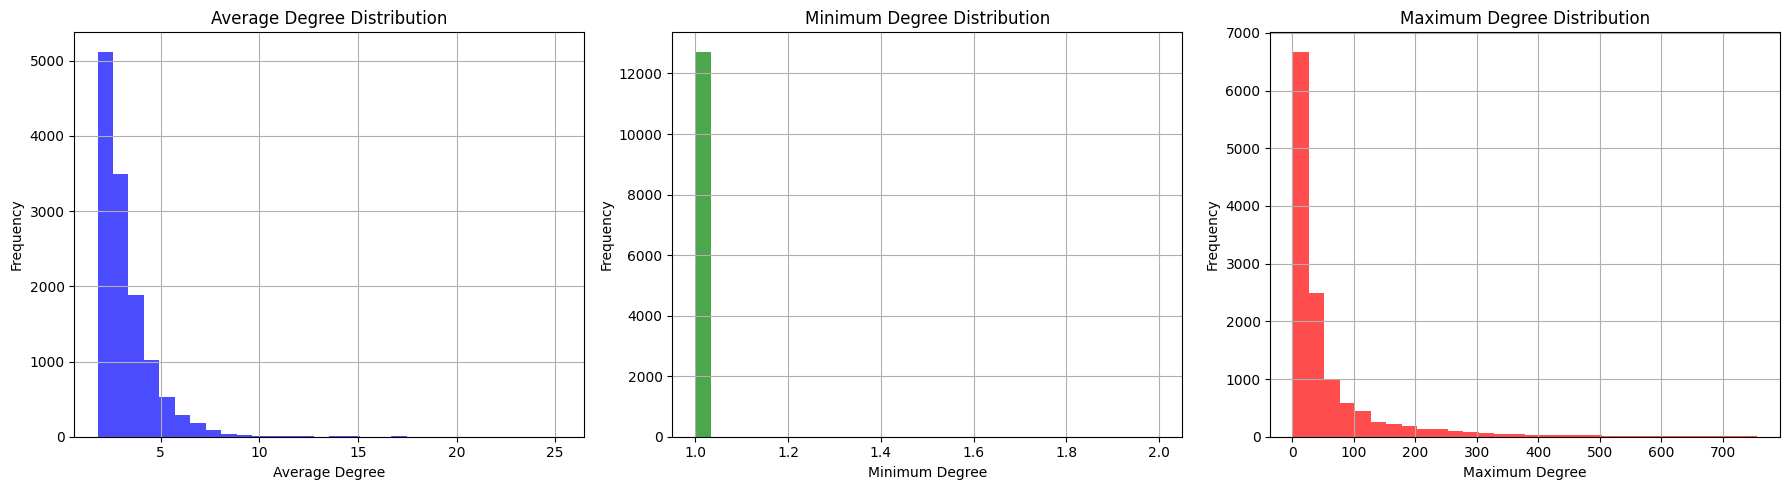

In [ ]:
average_degrees = []
min_degrees = []
max_degrees = []

# Collect degree statistics from all graphs
for i, g in enumerate(graphs):
    degrees = [g.degree(n) for n in g.nodes()]
    avg_degree = np.mean(degrees)
    min_degree = np.min(degrees)
    max_degree = np.max(degrees)

    average_degrees.append(avg_degree)
    min_degrees.append(min_degree)
    max_degrees.append(max_degree)

    # Print statistics for each graph
    print(f"Graph {i + 1}:")
    print(f"  Number of nodes: {g.number_of_nodes()}")
    print(f"  Number of edges: {g.number_of_edges()}")
    print(f"  Is the graph connected? {nx.is_connected(g)}")
    print(f"  Average degree: {avg_degree:.2f}")
    print(f"  Maximum degree: {max_degree}")
    print(f"  Minimum degree: {min_degree}")
    print("-" * 30)

# Create a subplot with 3 plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot average degrees
axes[0].hist(average_degrees, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Average Degree Distribution')
axes[0].set_xlabel('Average Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot minimum degrees
axes[1].hist(min_degrees, bins=30, color='green', alpha=0.7)
axes[1].set_title('Minimum Degree Distribution')
axes[1].set_xlabel('Minimum Degree')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Plot maximum degrees
axes[2].hist(max_degrees, bins=30, color='red', alpha=0.7)
axes[2].set_title('Maximum Degree Distribution')
axes[2].set_xlabel('Maximum Degree')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.tight_layout()
plt.show()


# Analysis

Degree Distribution

- Average Degree: Most graphs have a low average degree, indicating sparse connectivity.
- Minimum Degree: Nearly all graphs have nodes with a minimum degree of 1, showing peripheral connections.
- Maximum Degree: Some graphs contain hubs with very high degrees, influencing network structure.

Network Characteristics:

- Sparse Connectivity: Most networks are sparsely connected with few highly connected nodes.
- Hubs Presence: A few networks have nodes with many connections, acting as central points.



## 6. Graph Centralities
Below, we demonstrate an in-depth look at various centrality measures on **one**
selected graph (the first). Centrality measures indicate which nodes (in this
developer network) are most influential.

- **Degree Centrality**: Nodes with many direct connections.
- **Betweenness Centrality**: Nodes bridging different parts of the network.
- **Closeness Centrality**: Nodes quickly reaching others via short paths.
- **Eigenvector Centrality**: Nodes connected to other highly important nodes.
- **Katz & PageRank**  add indirect effects or directional flow.


In [ ]:
# Pick a single graph to analyze
sample_index = 0
sample_graph = graphs[sample_index]
print(f"Graph {sample_index} has {sample_graph.number_of_nodes()} nodes, {sample_graph.number_of_edges()} edges.")

# Helper to print top 5 nodes for any centrality measure
def print_top_5(centrality, name):
    sorted_c = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 nodes for {name}:")
    for node, val in sorted_c[:5]:
        print(f"Node: {node}, {name}: {val:.4f}")
    print()

# Helper to plot distribution
def plot_centrality_distribution(centrality, name):
    plt.figure(figsize=(10, 5))
    plt.hist(centrality.values(), bins=50, color='blue', alpha=0.7)
    plt.title(f'{name} Distribution')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Graph 0 has 71 nodes, 78 edges.


# 6.1 Degree Centrality


Top 5 nodes for Degree Centrality:
Node: 16, Degree Centrality: 0.4857
Node: 20, Degree Centrality: 0.0857
Node: 22, Degree Centrality: 0.0857
Node: 42, Degree Centrality: 0.0714
Node: 8, Degree Centrality: 0.0571



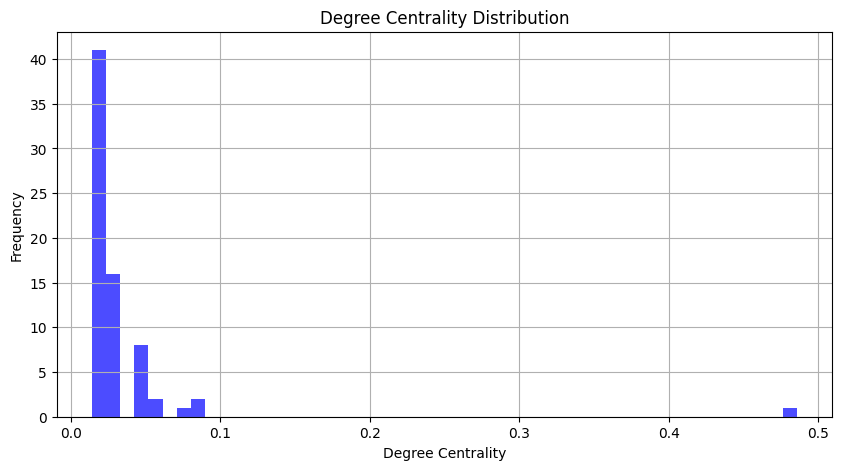

In [ ]:
degree_centrality = nx.degree_centrality(sample_graph)
print_top_5(degree_centrality, "Degree Centrality")
plot_centrality_distribution(degree_centrality, "Degree Centrality")

# Analysis

The node 16 has the highest degree centrality, indicating it is the most connected node in the network.
It likely plays a central role in the network's structure and could be a key influencer or hub. Followed by the second most connected with only 0.08 

Network Structure: 
- The presence of a few highly connected nodes (like Node 16) suggests a potential hub-and-spoke structure, where a few nodes act as central points connecting many others


# 6.2 Betweenness Centrality


Top 5 nodes for Betweenness Centrality:
Node: 16, Betweenness Centrality: 0.8333
Node: 42, Betweenness Centrality: 0.3127
Node: 8, Betweenness Centrality: 0.1743
Node: 22, Betweenness Centrality: 0.1444
Node: 12, Betweenness Centrality: 0.1283



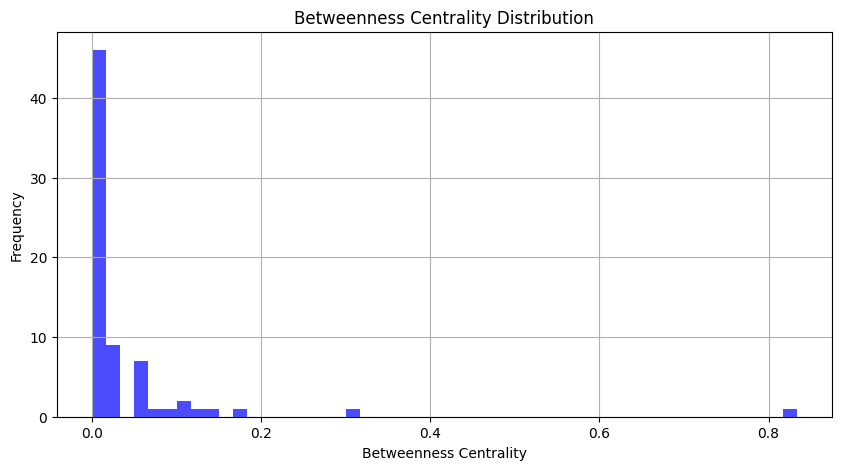

In [ ]:
betweenness_centrality = nx.betweenness_centrality(sample_graph)
print_top_5(betweenness_centrality, "Betweenness Centrality")
plot_centrality_distribution(betweenness_centrality, "Betweenness Centrality")

# Analysis

The node 16 has the highest betweenness centrality, indicating it is the most critical for connecting different parts of the network. It likely serves as a key intermediary or bridge in the network.


# 6.3 Closeness Centrality


Top 5 nodes for Closeness Centrality:
Node: 16, Closeness Centrality: 0.5072
Node: 42, Closeness Centrality: 0.4192
Node: 8, Closeness Centrality: 0.3955
Node: 68, Closeness Centrality: 0.3646
Node: 7, Closeness Centrality: 0.3518



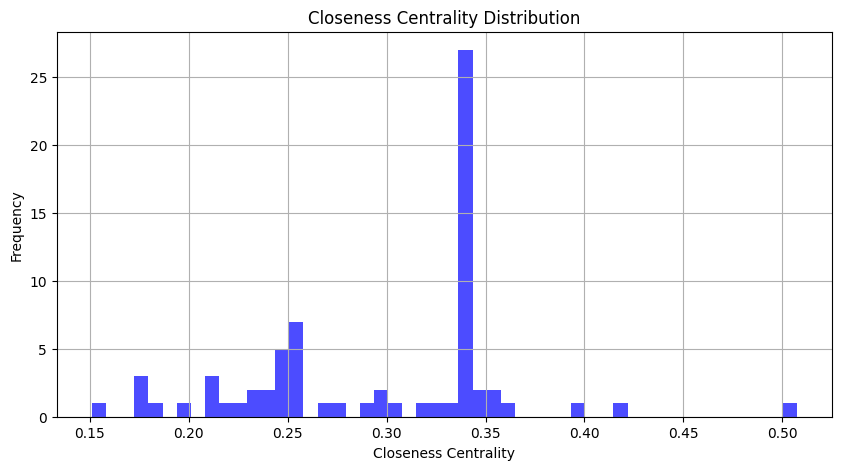

In [ ]:
closeness_centrality = nx.closeness_centrality(sample_graph)
print_top_5(closeness_centrality, "Closeness Centrality")
plot_centrality_distribution(closeness_centrality, "Closeness Centrality")

# Analysis

The network has a core-periphery structure, where a few central nodes can efficiently access others, while many nodes are less connected and again the node 16 is the central one which means it can reach other nodes more quickly than the rest.

# 6.4 Eigenvector Centrality


Top 5 nodes for Eigenvector Centrality:
Node: 16, Eigenvector Centrality: 0.6935
Node: 42, Eigenvector Centrality: 0.1463
Node: 8, Eigenvector Centrality: 0.1415
Node: 53, Eigenvector Centrality: 0.1404
Node: 58, Eigenvector Centrality: 0.1404



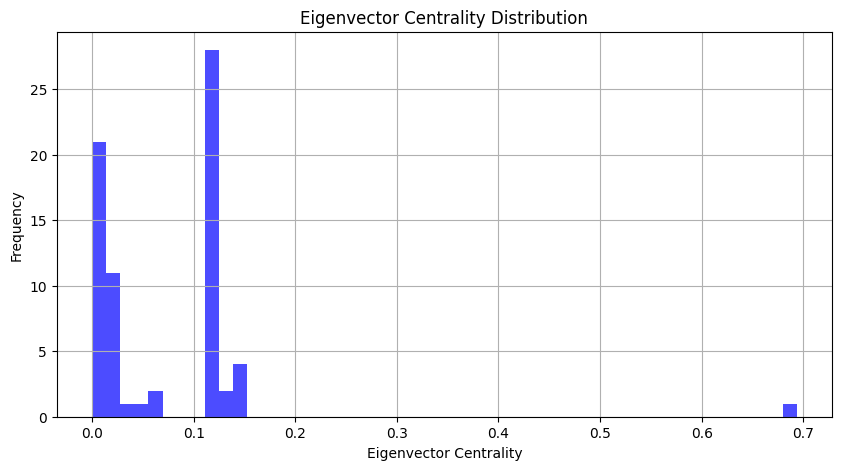

In [ ]:
try:
    eigenvector_centrality = nx.eigenvector_centrality(sample_graph, max_iter=1000)
    print_top_5(eigenvector_centrality, "Eigenvector Centrality")
    plot_centrality_distribution(eigenvector_centrality, "Eigenvector Centrality")
except:
    print("Eigenvector centrality failed to converge on this graph.")

# Analysis

The network has a highly centralized structure in terms of influence.

Node 16 plays again a critical role in connecting and influencing the rest of the network.

# 6.5  PageRank

Top 5 nodes for PageRank:
Node: 16, PageRank: 0.1976
Node: 22, PageRank: 0.0329
Node: 20, PageRank: 0.0325
Node: 42, PageRank: 0.0272
Node: 12, PageRank: 0.0246



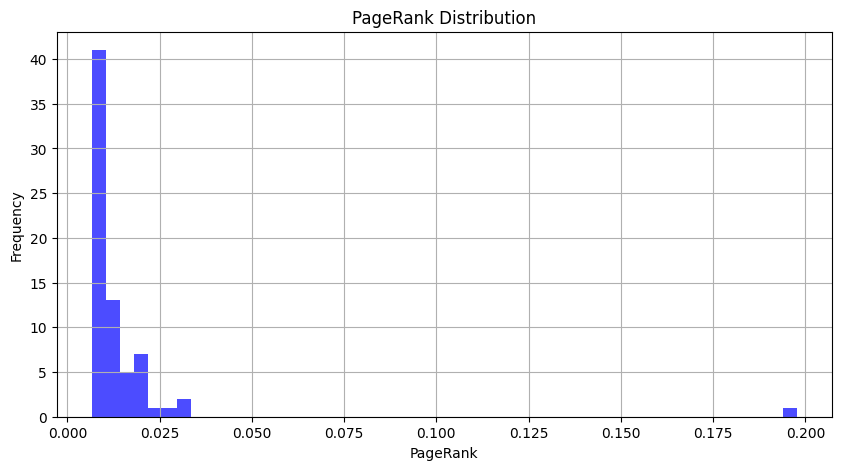

In [ ]:
pagerank_centrality = nx.pagerank(sample_graph, alpha=0.85)
print_top_5(pagerank_centrality, "PageRank")
plot_centrality_distribution(pagerank_centrality, "PageRank")

# Analysis

The PageRank results align closely with your eigenvector centrality and closeness centrality findings:
Node 16 is consistently the most central and influential node

### Interpretation
- **Degree**: devs with many direct follower connections.
- **Betweenness**: devs bridging communities.
- **Closeness**: devs with short paths to others, indicating broad influence.
- **Eigenvector**: devs connected to other well-connected devs.
- **PageRank**: devs who accumulate importance based on inbound connections.

Together, these can highlight key individuals in the dev network.

### 6.6 Borda Count
We combine the rankings from several centralities to get a single scoring.

In [ ]:
# Borda Count to determine the most central node
def borda_count(centralities):
    borda_scores = {}
    for cent in centralities:
        sorted_nodes = sorted(cent.keys(), key=lambda x: cent[x], reverse=True)
        for rank, node in enumerate(sorted_nodes):
            if node not in borda_scores:
                borda_scores[node] = 0
            # Higher rank => bigger contribution
            borda_scores[node] += (len(sorted_nodes) - rank)
    return borda_scores


all_centralities = [
    degree_centrality,
    betweenness_centrality,
    closeness_centrality
]
try:
    all_centralities.append(eigenvector_centrality)
except:
    pass
all_centralities.append(pagerank_centrality)

borda_scores = borda_count(all_centralities)
sorted_borda = sorted(borda_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 5 nodes based on Borda count:")
for node, score in sorted_borda[:5]:
    print(f"Node: {node}, Borda Score: {score}")

Top 5 nodes based on Borda count:
Node: 16, Borda Score: 355
Node: 42, Borda Score: 346
Node: 8, Borda Score: 340
Node: 11, Borda Score: 314
Node: 68, Borda Score: 301


## 7 Community Detection
We'll now run a simple Girvan-Newman on a subgraph (top 30 biggest-degree nodes).

Girvan-Newman split (first level): [39, 32]


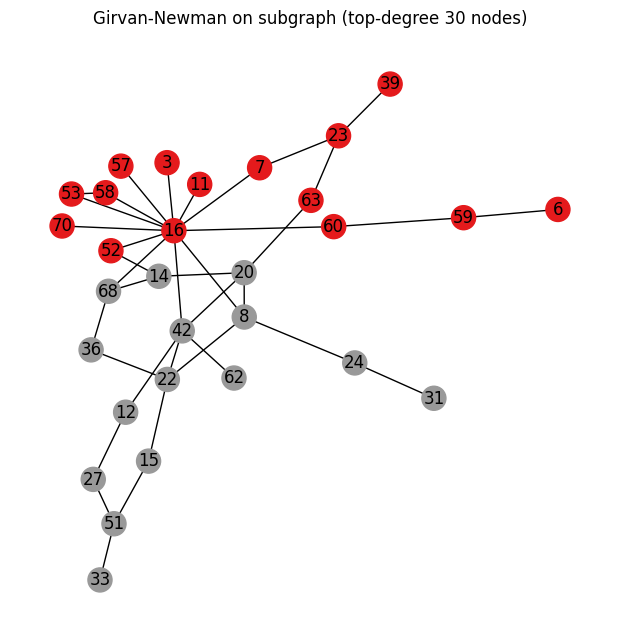

In [ ]:
gn_gen = community.girvan_newman(sample_graph)
first_level_communities = next(gn_gen)
print("Girvan-Newman split (first level):", [len(c) for c in first_level_communities])

big_nodes = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:30]]
subg = sample_graph.subgraph(big_nodes)

subg_gn = community.girvan_newman(subg)
subg_first = next(subg_gn)
list_communities = list(subg_first)

community_map = {}
for i, cset in enumerate(list_communities):
    for node in cset:
        community_map[node] = i

pos = nx.spring_layout(subg, seed=42)
colors = [community_map[n] for n in subg.nodes()]
plt.figure(figsize=(6, 6))
nx.draw(subg, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set1)
plt.title("Girvan-Newman on subgraph (top-degree 30 nodes)")
plt.show()

# Analysis

The Girvan-Newman result confirms a clear modular structure in our graph with node 16 acting as a central bridge node between at least two communities. 

This adds strong support to earlier centrality findings and suggests that targeting or monitoring this node could significantly impact the connectivity or flow within the network.

######

### 7.1 Additional Community Utilities
We define helper functions to print stats and to visualize aggregated communities.

In [ ]:
# Function to print community statistics
def print_community_stats(communities):
    print(f"Number of communities: {len(communities)}")
    sizes = [len(comm) for comm in communities]
    print(f"Community sizes: {sizes}")
    print(f"Largest community: {max(sizes)}")
    print(f"Smallest community: {min(sizes)}")
    print(f"Average community size: {np.mean(sizes):.2f}")
    print()

# Function to plot an aggregated community-graph
def plot_aggregated_communities(G, communities, title):
    community_graph = nx.Graph()
    for i, comm in enumerate(communities):
        community_graph.add_node(i, size=len(comm))
        for node in comm:
            for neighbor in G.neighbors(node):
                for j, other_comm in enumerate(communities):
                    if neighbor in other_comm and i != j:
                        if community_graph.has_edge(i, j):
                            community_graph[i][j]['weight'] += 1
                        else:
                            community_graph.add_edge(i, j, weight=1)

    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(community_graph, seed=42, k=10.0)

    edge_weights = [community_graph[i][j]['weight'] for i, j in community_graph.edges()]
    edge_colors = edge_weights

    norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    cmap = plt.get_cmap('viridis')

    nx.draw_networkx_nodes(community_graph, pos, node_size=300, node_color='lightblue', alpha=0.8, ax=ax)
    for node, (x, y) in pos.items():
        ax.text(x, y + 0.05, s=f"{community_graph.nodes[node]['size']}", 
                fontsize=10, ha='center', va='center', color='black')

    edges = nx.draw_networkx_edges(community_graph, pos, edge_color=edge_colors,
                                   width=2, alpha=0.6, edge_cmap=cmap, edge_vmin=min(edge_weights),
                                   edge_vmax=max(edge_weights), ax=ax)

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Edge Weight (Number of Connections)', shrink=0.8)

    nx.draw_networkx_labels(community_graph, pos, font_size=8, font_color='black', ax=ax)

    plt.title(title)
    plt.show()

### 7.2 Louvain Community Detection
Using python-louvain (community_louvain) to partition the full `sample_graph`.

Louvain Communities:
Number of communities: 10
Community sizes: [25, 2, 5, 5, 14, 2, 7, 3, 6, 2]
Largest community: 25
Smallest community: 2
Average community size: 7.10



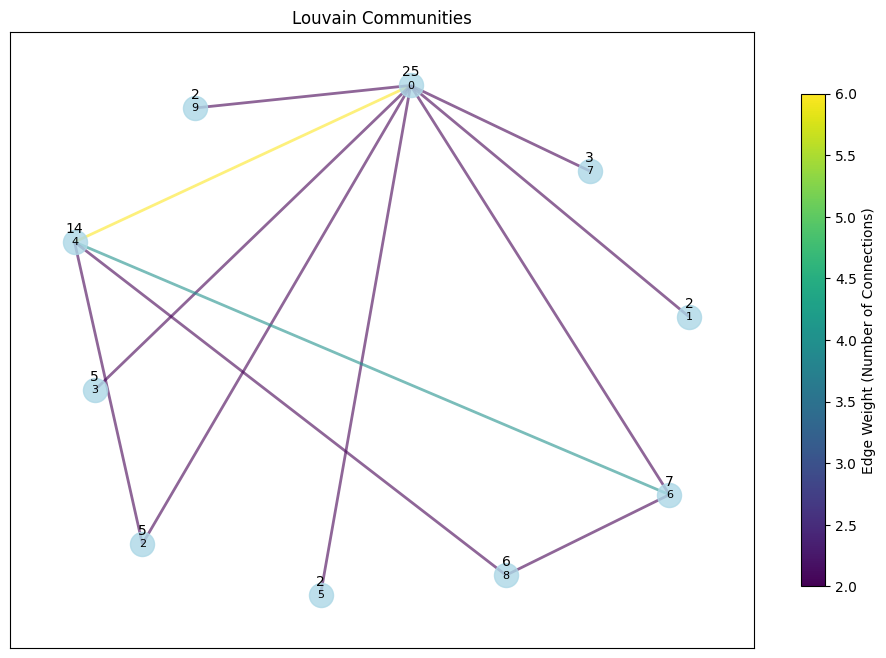

In [ ]:
try:
    def louvain_communities(G):
        partition = community_louvain.best_partition(G)
        comms = defaultdict(list)
        for node, comm_id in partition.items():
            comms[comm_id].append(node)
        return list(comms.values())

    print("Louvain Communities:")
    louvain_coms = louvain_communities(sample_graph)
    print_community_stats(louvain_coms)
    plot_aggregated_communities(sample_graph, louvain_coms, "Louvain Communities")
except:
    print("Install python-louvain to run Louvain.")

# Analysis

Well-Defined Communities
- The Louvain method identified a reasonably granular community structure (11 groups), which is good for large, non-uniform networks.

Dominant Core
- One community is significantly larger than the rest (25 nodes), suggesting a core group of densely connected nodes.

Diversity in Structure
- The presence of multiple small communities (2–4 nodes) indicates localized clusters, possibly loosely connected or with specific roles (like peripherals or bridge roles).

Edge Weight Context
- Higher-weight edges (yellow) may signify stronger relationships or more frequent interactions, which can be important when analyzing influence or flow of information.

######

### 8 Hierarchical Clustering
We demonstrate hierarchical clustering on the largest connected component.

Hierarchical Clustering Communities:


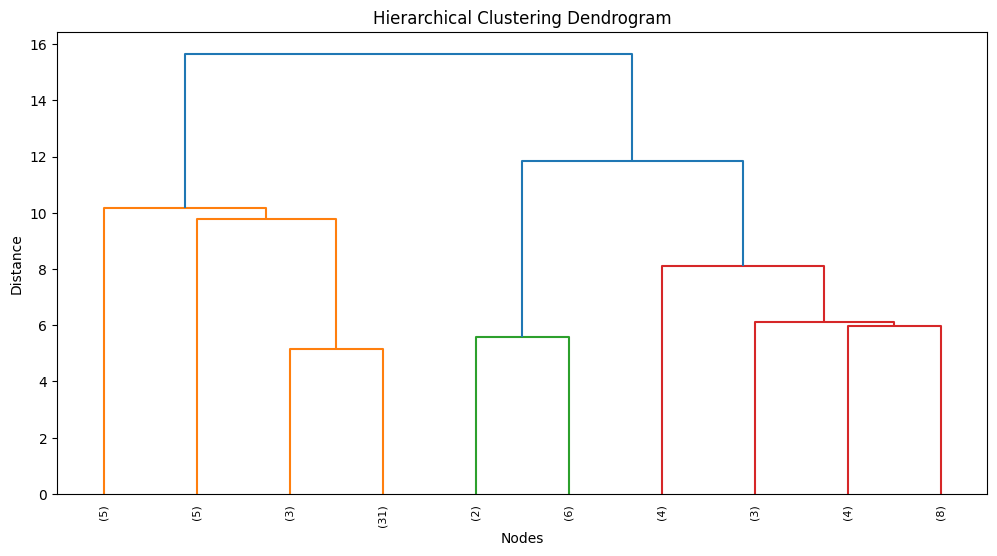

Number of communities: 17
Community sizes: [25, 2, 2, 2, 3, 3, 4, 4, 4, 2, 3, 3, 3, 4, 2, 2, 3]
Largest community: 25
Smallest community: 2
Average community size: 4.18



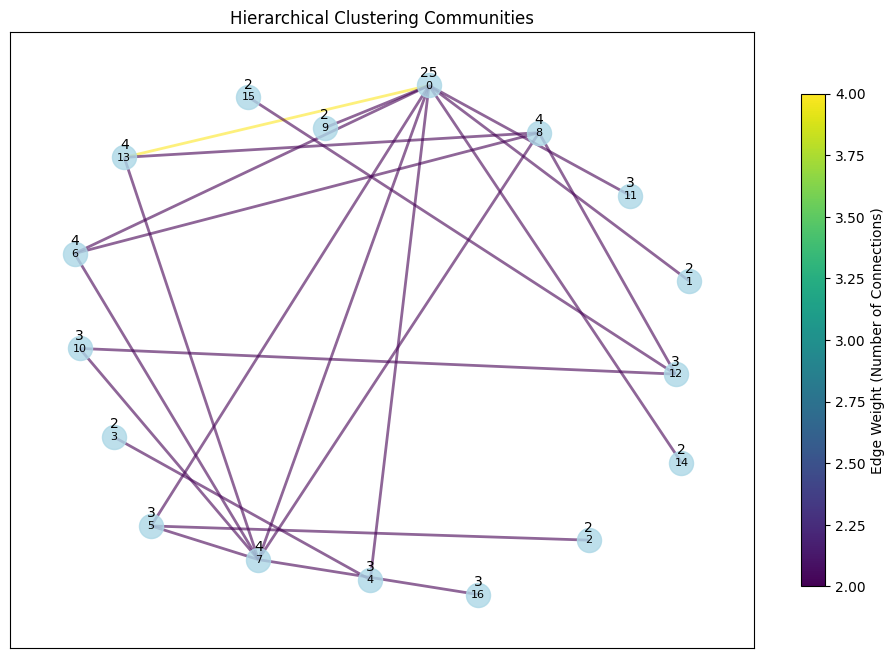

In [ ]:
def compute_distance_matrix(G):
    shortest_paths = dict(nx.shortest_path_length(G))
    distance_matrix = np.zeros((len(G), len(G)))
    nodes = list(G.nodes())
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if v in shortest_paths[u]:
                distance_matrix[i, j] = shortest_paths[u][v]
            else:
                distance_matrix[i, j] = nx.diameter(G) + 1
    return distance_matrix, nodes

def hierarchical_clustering(G, threshold=3):
    # largest connected component only
    G = G.subgraph(max(nx.connected_components(G), key=len))

    dist_matrix, nodes = compute_distance_matrix(G)
    condensed_distance = squareform(dist_matrix)

    Z = linkage(condensed_distance, method='ward')

    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=nodes, leaf_rotation=90, leaf_font_size=8, p=10, truncate_mode='lastp')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Nodes')
    plt.ylabel('Distance')
    plt.show()

    communities = fcluster(Z, t=threshold, criterion='distance')
    community_dict = defaultdict(list)
    for node, comm_id in zip(nodes, communities):
        community_dict[comm_id].append(node)
    return list(community_dict.values())

print("Hierarchical Clustering Communities:")
hier_coms = hierarchical_clustering(sample_graph, threshold=3)
print_community_stats(hier_coms)
plot_aggregated_communities(sample_graph, hier_coms, "Hierarchical Clustering Communities")

# Analysis

Core-Periphery Pattern which means one dominant community (size 25) acts as a hub, while most others are small further confirming what we've seen with Louvain, PageRank, and Eigenvector.



## 9 Silhouette 
We perform a basic silhouette analysis on the community assignments. Silhouette
score measures how similar nodes are to their own cluster compared to others,
using our precomputed distance matrix.

In [ ]:
# Helper to convert community format into cluster labels aligned with a given node_list
def community_to_labels(communities, node_list):
    label_map = {}
    # Assign a cluster label to each node
    for i, comm in enumerate(communities):
        for node in comm:
            label_map[node] = i

    # Create a label array for each node in node_list
    labels = []
    for n in node_list:
        # If a node isn't in any community, assign -1
        labels.append(label_map.get(n, -1))
    return labels

# Function to compute silhouette score given a Graph and a list of communities
def compute_silhouette_score(G, communities, threshold=3):
    # Work on the largest connected component
    Gcc = G.subgraph(max(nx.connected_components(G), key=len))
    dist_matrix, node_list = compute_distance_matrix(Gcc)

    # Filter communities to keep only nodes within Gcc
    comm_in_cc = []
    for c in communities:
        subc = [n for n in c if n in Gcc]
        if len(subc) > 0:
            comm_in_cc.append(subc)

    # Build cluster labels
    cluster_labels = community_to_labels(comm_in_cc, sorted(Gcc.nodes()))

    # Need at least 2 clusters for silhouette
    if len(set(cluster_labels)) < 2:
        print("Cannot compute silhouette with fewer than 2 clusters.")
        return None

    # Silhouette with 'precomputed' distance
    sil_score = silhouette_score(dist_matrix, cluster_labels, metric='precomputed')
    return sil_score

In [ ]:
try:
    if 'louvain_coms' in globals():
        sil_louvain = compute_silhouette_score(sample_graph, louvain_coms)
        if sil_louvain is not None:
            print(f"Silhouette score (Louvain): {sil_louvain:.4f}")
except:
    print("Louvain silhouette failed.")

# 2) Hierarchical
if 'hier_coms' in globals():
    sil_hier = compute_silhouette_score(sample_graph, hier_coms)
    if sil_hier is not None:
        print(f"Silhouette score (Hierarchical): {sil_hier:.4f}")

# 3) Girvan-Newman full graph, first level
GN_full_coms = list(first_level_communities)
if len(GN_full_coms) > 1:
    sil_gn = compute_silhouette_score(sample_graph, GN_full_coms)
    if sil_gn is not None:
        print(f"Silhouette score (Girvan-Newman, first level): {sil_gn:.4f}")

Silhouette score (Louvain): -0.2350
Silhouette score (Hierarchical): -0.2676
Silhouette score (Girvan-Newman, first level): -0.0013


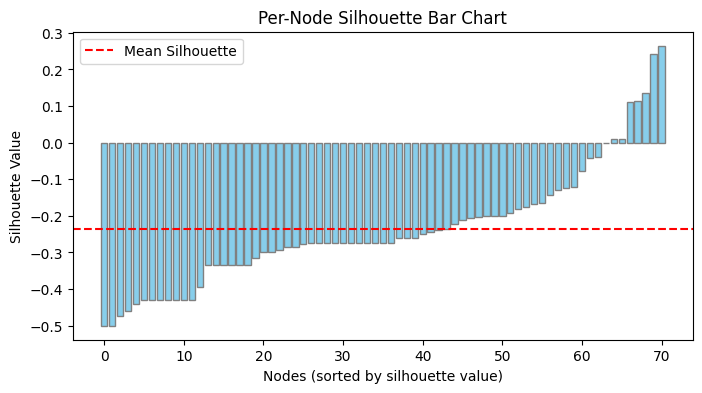

In [ ]:
def plot_silhouette_bars(G, communities, threshold=3):
    """
    Compute silhouette *per node* in the largest connected component,
    then visualize it as a bar chart.
    """
    # Work on the largest connected component
    Gcc = G.subgraph(max(nx.connected_components(G), key=len))
    dist_matrix, node_list = compute_distance_matrix(Gcc)

    # Filter communities so they only include nodes in this component
    comm_in_cc = []
    for c in communities:
        subc = [n for n in c if n in Gcc]
        if len(subc) > 0:
            comm_in_cc.append(subc)

    # Convert these communities to labels
    cluster_labels = community_to_labels(comm_in_cc, sorted(Gcc.nodes()))

    # Check if we have at least 2 clusters
    unique_clusters = set(cluster_labels)
    if len(unique_clusters) < 2:
        print("Cannot compute silhouette bars with fewer than 2 clusters.")
        return

    # Compute individual silhouette values
    sil_values = silhouette_samples(dist_matrix, cluster_labels, metric='precomputed')

    # Sort them just for a nicer plot; you could group them by cluster if you prefer
    sorted_sil = sorted(sil_values)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(sorted_sil)), sorted_sil, color='skyblue', edgecolor='gray')
    plt.axhline(np.mean(sil_values), color='red', linestyle='--', label='Mean Silhouette')
    plt.xlabel("Nodes (sorted by silhouette value)")
    plt.ylabel("Silhouette Value")
    plt.title("Per-Node Silhouette Bar Chart")
    plt.legend()
    plt.show()

plot_silhouette_bars(sample_graph, louvain_coms)


# Analysis

Despite the intuitive visual community structures from Louvain and Hierarchical clustering, the silhouette analysis reveals that these partitions may not be strongly supported by the graph’s internal node distances.

#####

## 9.1 Community Detection with Leiden and Silhouette Evaluation


Leiden community sizes: [8, 7, 4, 4, 4, 3]


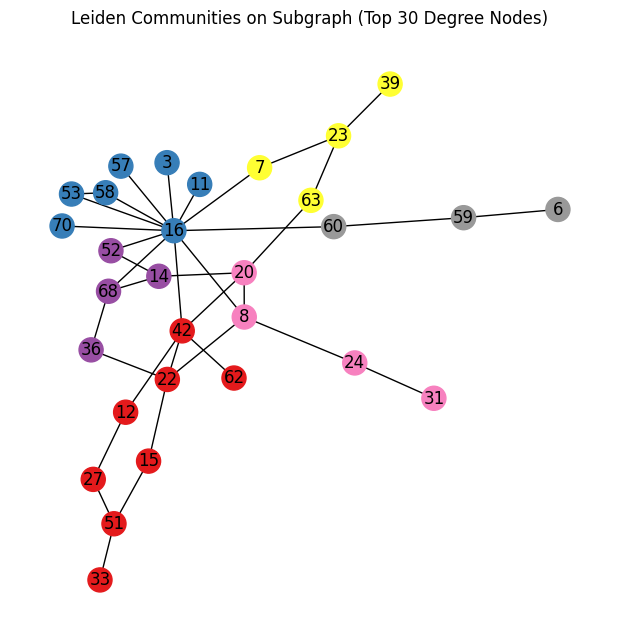

In [ ]:
big_nodes = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:30]]
subg = sample_graph.subgraph(big_nodes).copy()
edges = list(subg.edges())
g_igraph = ig.Graph.TupleList(edges, directed=False)
partition = leidenalg.find_partition(g_igraph, leidenalg.ModularityVertexPartition)

# Convert iGraph community output to list of nodes
leiden_coms = []
for community in partition:
    leiden_coms.append([int(g_igraph.vs[idx]["name"]) for idx in community])  

print("Leiden community sizes:", [len(c) for c in leiden_coms])

# Plot communities in the subgraph 
community_map = {}
for i, cset in enumerate(leiden_coms):
    for node in cset:
        community_map[node] = i

pos = nx.spring_layout(subg, seed=42)
colors = [community_map[n] for n in subg.nodes()]
plt.figure(figsize=(6, 6))
nx.draw(subg, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set1)
plt.title("Leiden Communities on Subgraph (Top 30 Degree Nodes)")
plt.show()


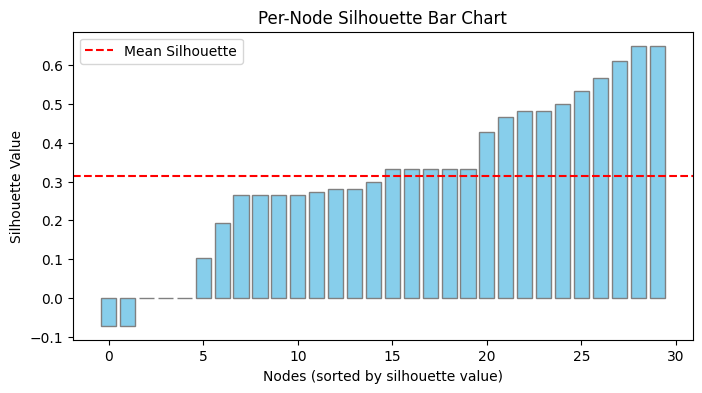

In [ ]:
plot_silhouette_bars(subg, leiden_coms)


# Analysis

Visually, the communities are compact and well-separated and the node coloring shows clear modular structure with very little overlap.

Most nodes have silhouette > 0, indicating they're well-assigned. Only 4 nodes have slightly negative values indicating minimal misclassification. Mean silhouette is positive, showing strong internal cohesion and good separation between communities.

We can conclude the Leiden Comunities performed significantly better than Louvain, Hierarchical, and Girvan-Newman.

## 10. Spectral vs. Node2Vec Embeddings
We'll do a quick demonstration on the same single graph.

/Users/gabriellima/Documents/CentraleSupelec/Mention/GraphsMining/GraphMining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 936.10it/s]


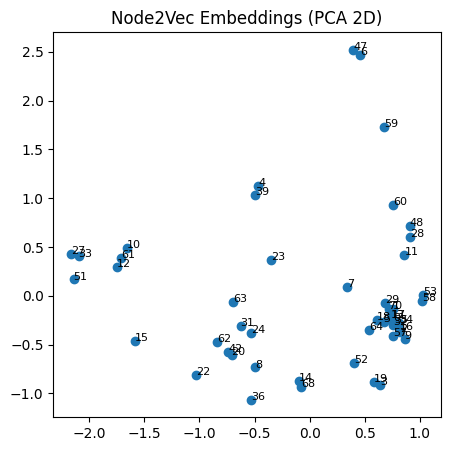

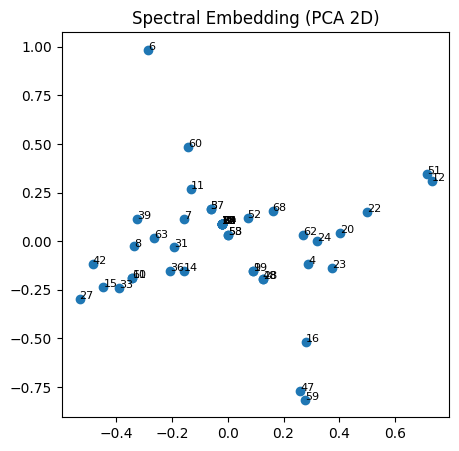

In [ ]:
big_nodes_50 = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:50]]
g_sub = sample_graph.subgraph(big_nodes_50).copy()

# Node2Vec Embedding
try:
    from node2vec import Node2Vec
    node2vec_model = Node2Vec(g_sub, dimensions=16, walk_length=10, num_walks=50, workers=1)
    n2v = node2vec_model.fit(window=5, min_count=1)

    emb_array = []
    node_list = list(g_sub.nodes())
    for node in node_list:
        if str(node) in n2v.wv:
            emb_array.append(n2v.wv[str(node)])
        else:
            emb_array.append(np.zeros(16))
    emb_array = np.array(emb_array)

    pca_2d = PCA(n_components=2)
    node2vec_2d = pca_2d.fit_transform(emb_array)

    plt.figure(figsize=(5, 5))
    plt.scatter(node2vec_2d[:, 0], node2vec_2d[:, 1])
    for i, nd in enumerate(node_list):
        plt.text(node2vec_2d[i, 0], node2vec_2d[i, 1], str(nd), fontsize=8)
    plt.title("Node2Vec Embeddings (PCA 2D)")
    plt.show()

except ImportError:
    print("Please install node2vec via pip install node2vec")

# Spectral Embedding
lap = nx.normalized_laplacian_matrix(g_sub)
lapdense = lap.todense()

pca_spec = PCA(n_components=2)
spectral_2d = pca_spec.fit_transform(lapdense)

plt.figure(figsize=(5, 5))
plt.scatter(spectral_2d[:, 0], spectral_2d[:, 1])
for i, nd in enumerate(g_sub.nodes()):
    plt.text(spectral_2d[i, 0], spectral_2d[i, 1], str(nd), fontsize=8)
plt.title("Spectral Embedding (PCA 2D)")
plt.show()

# Analysis

Node2Vec shows strong potential for detecting core clusters or central nodes.

We have a clear cluster on the right, where many nodes (dense labels) are tightly packed likely a community or tightly connected core.



Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 8438.90it/s]


Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 460.23it/s]


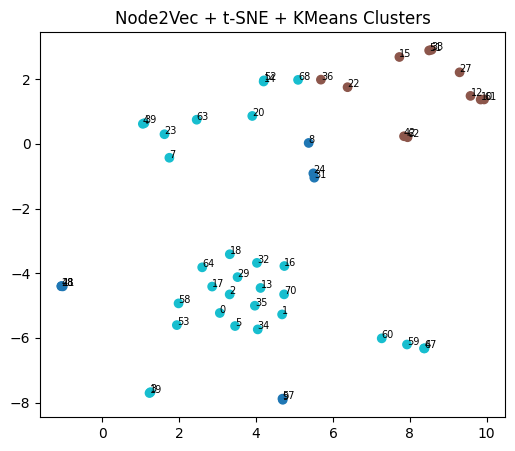

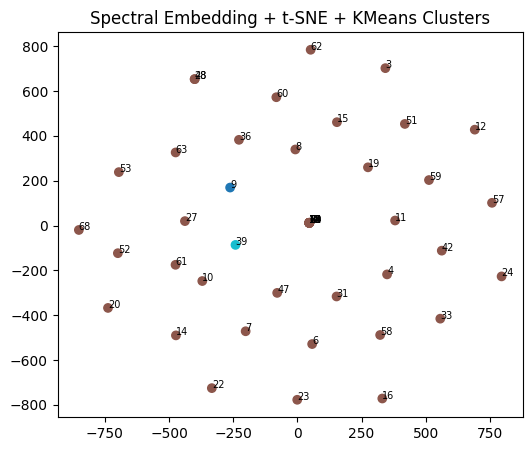

In [ ]:
#Node2Vec Embedding + t-SNE + KMeans
# Node2Vec model
node2vec_model = Node2Vec(g_sub, dimensions=16, walk_length=10, num_walks=50, workers=1, seed=42)
n2v = node2vec_model.fit(window=5, min_count=1)

node_list = list(g_sub.nodes())
emb_array = [n2v.wv[str(node)] if str(node) in n2v.wv else np.zeros(16) for node in node_list]
emb_array = np.array(emb_array)

# Standardize before clustering and t-SNE
scaler = StandardScaler()
emb_array_scaled = scaler.fit_transform(emb_array)

# t-SNE
tsne_n2v = TSNE(n_components=2, random_state=42, perplexity=15, init='pca')
n2v_tsne = tsne_n2v.fit_transform(emb_array_scaled)

# KMeans clustering
kmeans_n2v = KMeans(n_clusters=3, random_state=42)
labels_n2v = kmeans_n2v.fit_predict(emb_array_scaled)

# Plot Node2Vec t-SNE with KMeans clusters
plt.figure(figsize=(6, 5))
plt.scatter(n2v_tsne[:, 0], n2v_tsne[:, 1], c=labels_n2v, cmap='tab10')
for i, node in enumerate(node_list):
    plt.text(n2v_tsne[i, 0], n2v_tsne[i, 1], str(node), fontsize=7)
plt.title("Node2Vec + t-SNE + KMeans Clusters")
plt.show()


# Spectral Embedding + t-SNE + KMeans
# Spectral embedding (using normalized Laplacian)
lap = nx.normalized_laplacian_matrix(g_sub).todense()

# Reduce with PCA first if needed (optional here since lap is already dense)
pca_spectral = PCA(n_components=16)
spec_emb = pca_spectral.fit_transform(lap)

# Standardize
spec_emb_scaled = scaler.fit_transform(spec_emb)

# t-SNE
tsne_spec = TSNE(n_components=2, random_state=42, perplexity=15, init='pca')
spec_tsne = tsne_spec.fit_transform(spec_emb_scaled)

# KMeans clustering
kmeans_spec = KMeans(n_clusters=3, random_state=42)
labels_spec = kmeans_spec.fit_predict(spec_emb_scaled)

# Plot Spectral t-SNE with KMeans clusters
plt.figure(figsize=(6, 5))
plt.scatter(spec_tsne[:, 0], spec_tsne[:, 1], c=labels_spec, cmap='tab10')
for i, node in enumerate(node_list):
    plt.text(spec_tsne[i, 0], spec_tsne[i, 1], str(node), fontsize=7)
plt.title("Spectral Embedding + t-SNE + KMeans Clusters")
plt.show()


# Analysis

Node2Vec + t-SNE + KMeans -> Clustering is well-formed: We can clearly see 3 separate groups, with minimal overlap. This confirms that Node2Vec captures latent network features effectively.

Spectral Embedding + t-SNE + KMeans -> Clusters are not clearly separated points are spread almost uniformly across the plot. This suggests Spectral Embedding is not capturing strong modular structure, or the graph lacks clear partitions under this method.

